In [ ]:
!pip install prophet

In [ ]:
!pip install pandas matplotlib scikit-learn

In [ ]:
pip install mlflow

In [58]:
import pandas as pd

def check_data_quality(df):
    print("Checking for missing values")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    print("\nChecking for duplicate values")
    duplicate_values = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_values}")

    print("\nChecking for multiple entries based on a key column")
    key_column = input("Enter the column name to check for multiple entries: ")
    if key_column in df.columns:
        multiple_entries = df[key_column].value_counts()
        print(multiple_entries[multiple_entries > 1])
    else:
        print("Invalid column name entered.")

# Example Usage
df = pd.read_csv("ML.csv")  # Load your dataset
check_data_quality(df)

Checking for missing values
lag_1              8
lag_7             56
rolling_mean_7    48
dtype: int64

Checking for duplicate values
Number of duplicate rows: 0

Checking for multiple entries based on a key column
Enter the column name to check for multiple entries: Date
Date
01-03-2019    8
01-04-2023    8
12/29/22      8
12/30/22      8
12/31/22      8
             ..
12/27/20      8
12/26/20      8
12/25/20      8
12/24/20      8
12/31/24      8
Name: count, Length: 2190, dtype: int64


In [59]:
#7 Days forecast
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files
import io
import os
from datetime import datetime
from prophet.diagnostics import cross_validation, performance_metrics

# Function to upload a dataset from local computer
def upload_dataset():
    """
    Upload a CSV file through Google Colab's file uploader.

    Returns:
        pd.DataFrame: The uploaded dataset
    """
    print("Please upload your CSV file containing sales data")
    uploaded = files.upload()

    if not uploaded:
        raise ValueError("No file was uploaded")

    # Get the filename and read the CSV
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[filename]))

    print(f"Dataset '{filename}' uploaded successfully with {len(df)} rows")

    # Check for required columns
    required_columns = ['Date', 'Total Quantity']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    print("Dataset preview:")
    display(df.head())

    return df, filename

def calculate_metrics(actual, predicted):
    """Calculate error metrics between actual and predicted values."""
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    # Calculate MAPE while avoiding division by zero
    mask = actual != 0
    mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

    return mae, mse, rmse, mape, r2

def handle_outliers(df, column='y', method='iqr', threshold=1.5):
    """
    Handle outliers in the data.

    Args:
        df (pd.DataFrame): Input dataframe
        column (str): Column to check for outliers
        method (str): Method to use ('iqr' or 'zscore')
        threshold (float): Threshold for outlier detection

    Returns:
        pd.DataFrame: Dataframe with outliers handled
    """
    df_clean = df.copy()

    if method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        print(f"Found {outliers.sum()} outliers using IQR method")

        # Replace outliers with bounds instead of removing them
        df_clean.loc[df[column] < lower_bound, column] = lower_bound
        df_clean.loc[df[column] > upper_bound, column] = upper_bound

    elif method == 'zscore':
        from scipy import stats
        z_scores = np.abs(stats.zscore(df[column]))
        outliers = z_scores > threshold
        print(f"Found {outliers.sum()} outliers using Z-score method")

        # Replace outliers with median
        median_value = df[column].median()
        df_clean.loc[outliers, column] = median_value

    return df_clean

def preprocess_data(df, years=3, handle_outliers_flag=True):
    """
    Preprocess the data for Prophet modeling.

    Args:
        df (pd.DataFrame): Input dataframe
        years (int): Number of years of data to use
        handle_outliers_flag (bool): Whether to handle outliers

    Returns:
        pd.DataFrame: Processed dataframe ready for Prophet
    """
    # Make a copy to avoid modifying the original
    df_copy = df.copy()

    # Convert Date to datetime with flexible format handling
    try:
        # First try automatic parsing
        df_copy['Date'] = pd.to_datetime(df_copy['Date'], errors='raise')
    except:
        # If that fails, try common formats
        try:
            # Try MM/DD/YY
            df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%m/%d/%y', errors='raise')
        except:
            try:
                # Try MM/DD/YYYY
                df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%m/%d/%Y', errors='raise')
            except:
                try:
                    # Try YYYY-MM-DD
                    df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%Y-%m-%d', errors='raise')
                except:
                    try:
                        # Try DD/MM/YYYY
                        df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%d/%m/%Y', errors='raise')
                    except:
                        try:
                            # Try with inferred format and dayfirst
                            df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='mixed', dayfirst=True, errors='raise')
                        except:
                            # Last attempt with inferred format and dayfirst=False
                            df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='mixed', dayfirst=False)

    print(f"Date range in dataset: {df_copy['Date'].min()} to {df_copy['Date'].max()}")

    # Filter to only keep the last `years` years of data
    if years:
        cutoff_date = df_copy['Date'].max() - pd.DateOffset(years=years)
        df_copy = df_copy[df_copy['Date'] >= cutoff_date]
        print(f"Using data from {cutoff_date} to {df_copy['Date'].max()}")

    # Group by date and sum the quantities
    daily_data = df_copy.groupby('Date')['Total Quantity'].sum().reset_index()

    # Rename columns for Prophet (requires 'ds' for dates and 'y' for target)
    daily_data = daily_data.rename(columns={'Date': 'ds', 'Total Quantity': 'y'})

    # Handle outliers if requested
    if handle_outliers_flag:
        daily_data = handle_outliers(daily_data, column='y', method='iqr', threshold=2.0)

    return daily_data

def add_features(df):
    """
    Add time-based features to the dataframe.

    Args:
        df (pd.DataFrame): Input dataframe with 'ds' column

    Returns:
        pd.DataFrame: Dataframe with additional features
    """
    # Create a copy of the dataframe to avoid modifying the original
    result = df.copy()

    # Extract date features
    result['day_of_week'] = result['ds'].dt.dayofweek
    result['is_weekend'] = result['day_of_week'].isin([5, 6]).astype(int)
    result['day_of_month'] = result['ds'].dt.day
    result['day_of_year'] = result['ds'].dt.dayofyear
    result['month'] = result['ds'].dt.month
    result['week_of_year'] = result['ds'].dt.isocalendar().week

    # Add lag features
    result['lag_1'] = result['y'].shift(1)
    result['lag_7'] = result['y'].shift(7)

    # Add rolling mean
    result['rolling_mean_7'] = result['y'].rolling(window=7, min_periods=1).mean()

    # Drop NaN values
    result = result.dropna()

    return result

def find_optimal_parameters(df, initial='180 days', period='30 days', horizon='90 days'):
    """
    Find optimal parameters for Prophet model using cross-validation.

    Args:
        df (pd.DataFrame): Input dataframe with 'ds' and 'y' columns

    Returns:
        dict: Dictionary of optimal parameters
    """
    print("Finding optimal parameters using cross-validation...")

    # Define parameter grid (using a simplified grid to avoid overfitting)
    param_grid = {
        'changepoint_prior_scale': [0.01, 0.05, 0.1],
        'seasonality_prior_scale': [0.1, 1.0, 10.0]
    }

    # Perform grid search
    results = []
    best_rmse = float('inf')
    best_params = {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0}

    total_combinations = len(param_grid['changepoint_prior_scale']) * len(param_grid['seasonality_prior_scale'])
    current = 0

    for cp in param_grid['changepoint_prior_scale']:
        for sp in param_grid['seasonality_prior_scale']:
            current += 1
            print(f"Testing parameters {current}/{total_combinations}: cp={cp}, sp={sp}")

            # Create model with current parameters
            model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                seasonality_mode='multiplicative',
                changepoint_prior_scale=cp,
                seasonality_prior_scale=sp
            )

            model.fit(df)

            # Perform cross-validation
            try:
                df_cv = cross_validation(
                    model=model,
                    initial=initial,
                    period=period,
                    horizon=horizon,
                    parallel='processes'
                )

                # Calculate metrics
                df_p = performance_metrics(df_cv)
                rmse = df_p['rmse'].mean()

                results.append((cp, sp, rmse))
                print(f"  RMSE: {rmse:.4f}")

                # Update best parameters if needed
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {'changepoint_prior_scale': cp, 'seasonality_prior_scale': sp}
            except Exception as e:
                print(f"  Error during cross-validation: {e}")
                continue

    print(f"Best parameters: changepoint_prior_scale={best_params['changepoint_prior_scale']}, "
          f"seasonality_prior_scale={best_params['seasonality_prior_scale']}, RMSE={best_rmse:.4f}")

    return best_params

def train_prophet(df, years=3, forecast_days=7, optimize=True, handle_outliers_flag=True):
    """
    Train a Prophet model on the data and forecast future values.

    Args:
        df (pd.DataFrame): Input dataframe
        years (int): Number of years of data to use
        forecast_days (int): Number of days to forecast
        optimize (bool): Whether to optimize parameters
        handle_outliers_flag (bool): Whether to handle outliers

    Returns:
        tuple: The Prophet model and forecast dataframe
    """
    # Get preprocessed data
    prophet_df = preprocess_data(df, years, handle_outliers_flag)

    # Add features (though Prophet handles seasonality internally)
    df_with_features = add_features(prophet_df)

    # Print the dataset shape after preprocessing
    print(f"Training on {len(prophet_df)} data points")

    # Display aggregated data before training
    print("\nAggregated data preview:")
    display(prophet_df.head())

    # Find optimal parameters if requested
    if optimize and len(prophet_df) >= 180:  # Only optimize if we have enough data
        best_params = find_optimal_parameters(prophet_df)
        changepoint_prior_scale = best_params['changepoint_prior_scale']
        seasonality_prior_scale = best_params['seasonality_prior_scale']
    else:
        # Default parameters
        changepoint_prior_scale = 0.05
        seasonality_prior_scale = 10.0

    # Create and train the Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )

    # Add country holidays (US holidays as an example)
    model.add_country_holidays(country_name='US')

    # Fit the model
    model.fit(prophet_df)

    # Create future dataframe for prediction
    future = model.make_future_dataframe(periods=forecast_days)

    # Make predictions
    forecast = model.predict(future)

    # Evaluate the model on the last forecast_days points
    if len(prophet_df) >= forecast_days:
        # Get the last forecast_days actual values
        actual = prophet_df['y'].iloc[-forecast_days:].values
        # Get the corresponding predictions
        predicted = forecast['yhat'].iloc[-(2*forecast_days):-forecast_days].values

        # Calculate metrics
        mae, mse, rmse, mape, r2 = calculate_metrics(actual, predicted)

        print(f"\nModel Evaluation Metrics:")
        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f}")

    # Print the forecast for the next forecast_days
    future_forecast = forecast.iloc[-forecast_days:]
    print(f"\nForecast for the next {forecast_days} days:")

    # Create a table for display in Colab
    forecast_table = pd.DataFrame({
        'Date': future_forecast['ds'].dt.date,
        'Forecast': future_forecast['yhat'].round(2),
        'Lower Bound': future_forecast['yhat_lower'].round(2),
        'Upper Bound': future_forecast['yhat_upper'].round(2)
    })

    display(forecast_table)

    return model, forecast

def download_results(forecast, original_filename):
    """
    Prepare forecast results for download.

    Args:
        forecast (pd.DataFrame): Forecast dataframe
        original_filename (str): Original dataset filename
    """
    # Create simplified forecast dataframe
    download_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    download_df.columns = ['Date', 'Forecast', 'Lower_Bound', 'Upper_Bound']

    # Generate output filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f"prophet_forecast_{timestamp}.csv"

    # Save to CSV
    download_df.to_csv(output_filename, index=False)

    # Provide download link
    files.download(output_filename)

    return output_filename

# Main executable cell
def run_prophet_forecasting():
    try:
        # Upload dataset
        print("Step 1: Upload your dataset")
        df, filename = upload_dataset()

        # Get user parameters
        years_input = input("Enter number of years to use for training (default: 3): ")
        years = int(years_input) if years_input.strip() and years_input.isdigit() else 3

        forecast_days_input = input("Enter number of days to forecast (default: 7): ")
        forecast_days = int(forecast_days_input) if forecast_days_input.strip() and forecast_days_input.isdigit() else 7

        optimize_input = input("Optimize model parameters? (y/n, default: y): ")
        optimize = optimize_input.lower() != 'n' if optimize_input.strip() else True

        handle_outliers_input = input("Handle outliers? (y/n, default: y): ")
        handle_outliers = handle_outliers_input.lower() != 'n' if handle_outliers_input.strip() else True

        print(f"\nStep 2: Training Prophet model using {years} years of data and forecasting {forecast_days} days ahead")
        print(f"Parameter optimization: {'Enabled' if optimize else 'Disabled'}")
        print(f"Outlier handling: {'Enabled' if handle_outliers else 'Disabled'}")

        # Train the model
        model, forecast = train_prophet(df, years, forecast_days, optimize, handle_outliers)


        # Prepare download
        print("\nStep 4: Preparing forecast for download")
        output_file = download_results(forecast, filename)
        print(f"Forecast saved as {output_file}")

        print("\nForecasting complete!")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

# Run the forecasting process
run_prophet_forecasting()

Step 1: Upload your dataset
Please upload your CSV file containing sales data


Saving ML.csv to ML (2).csv
Dataset 'ML (2).csv' uploaded successfully with 17520 rows
Dataset preview:


,Date,Product Name,Total Quantity,day_of_week,is_weekend,day_of_month,day_of_year,month,week_of_year,lag_1,lag_7,rolling_mean_7
0,01-03-2019,beef,100,4,0,3,3,1,1,NaN,NaN,NaN
1,01-03-2019,corn,82,4,0,3,3,1,1,NaN,NaN,NaN
2,01-03-2019,milk,213,4,0,3,3,1,1,NaN,NaN,NaN
3,01-03-2019,sugar,70,4,0,3,3,1,1,NaN,NaN,NaN
4,01-03-2019,wheat,258,4,0,3,3,1,1,NaN,NaN,NaN


Enter number of years to use for training (default: 3): 5
Enter number of days to forecast (default: 7): 7
Optimize model parameters? (y/n, default: y): y
Handle outliers? (y/n, default: y): y

Step 2: Training Prophet model using 5 years of data and forecasting 7 days ahead
Parameter optimization: Enabled
Outlier handling: Enabled
Date range in dataset: 2019-01-02 00:00:00 to 2024-12-31 00:00:00
Using data from 2019-12-31 00:00:00 to 2024-12-31 00:00:00
Found 2 outliers using IQR method
Training on 1828 data points

Aggregated data preview:


,ds,y
0,2019-12-31,1213.0
1,2020-01-01,1143.0
2,2020-01-02,1126.0
3,2020-01-03,1131.0
4,2020-01-04,1056.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/m39fj1o9.json


Finding optimal parameters using cross-validation...
Testing parameters 1/9: cp=0.01, sp=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/vgd02s0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29856', 'data', 'file=/tmp/tmp4v5bzrku/m39fj1o9.json', 'init=/tmp/tmp4v5bzrku/vgd02s0h.json', 'output', 'file=/tmp/tmp4v5bzrku/prophet_modelhg9w6srt/prophet_model-20250311055053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:50:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:50:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-07-25 00:00:00 and 2024-10-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e3527a329d0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/uqkdgcbn.json
DEBUG:cmdstanpy:input tempfile:

  RMSE: 76.6378
Testing parameters 2/9: cp=0.01, sp=1.0


05:51:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-07-25 00:00:00 and 2024-10-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e3527d5ddd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/7sgpgxgj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/w6hwe7se.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/_dmfep01.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37749', 'data', 'file=/tmp/tmp4v5bzrku/7sgpgxgj.json', 'init=/tmp/tmp4v5bzrku/_dmfep01.json', 'output', 'file=/tmp/tmp4v5bzrku/prophet_modelogcls0o6/prophet_model-20250311055109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:51:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

  RMSE: 76.7458
Testing parameters 3/9: cp=0.01, sp=10.0


05:51:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-07-25 00:00:00 and 2024-10-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e35275edcd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/5dgrg40w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/3j2rkwnj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/k98xomkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/2kq8e9xc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42617', 'data', 'file=/tmp/tmp4v5bzrku/3j2rkwnj.json', 'init=/tmp/tmp4v5bzrku/k98xomkf.json', 'output', 'file=/tmp/tmp4v5bzrku/prophet_modelq4n9hy17/prophet_model-2025

  RMSE: 77.1270
Testing parameters 4/9: cp=0.05, sp=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/r97sima8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55544', 'data', 'file=/tmp/tmp4v5bzrku/99zh6txb.json', 'init=/tmp/tmp4v5bzrku/r97sima8.json', 'output', 'file=/tmp/tmp4v5bzrku/prophet_modelt4va05cc/prophet_model-20250311055144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:51:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:51:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-07-25 00:00:00 and 2024-10-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e3527ab9c90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/_b8o46lt.json
DEBUG:cmdstanpy:input tempfile:

  RMSE: 78.0200
Testing parameters 5/9: cp=0.05, sp=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/19rtqyiz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72903', 'data', 'file=/tmp/tmp4v5bzrku/uj8nv6pa.json', 'init=/tmp/tmp4v5bzrku/19rtqyiz.json', 'output', 'file=/tmp/tmp4v5bzrku/prophet_model7f32evks/prophet_model-20250311055203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:52:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:52:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-07-25 00:00:00 and 2024-10-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e3527630650>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/znwgi_b0.json
DEBUG:cmdstanpy:input tempfile:

  RMSE: 82.2171
Testing parameters 6/9: cp=0.05, sp=10.0


05:52:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-07-25 00:00:00 and 2024-10-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e3527d84b90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/7xfqfh91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/kukq2lmd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/tz7ivjwn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/hjkbmqhc.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45942', 'data', 'file=/tmp/tmp4v5bzrku/7xfqfh91.json', 'init=/tmp/tmp4v5bzrku/tz7ivjwn.json', 'output', 'file=/tmp/tmp4v5bzrku/prophet_modelw0x34b1z/prophet_model-20250311055222.csv', 'method=optimize', 'algorithm=lbfg

  RMSE: 82.6149
Testing parameters 7/9: cp=0.1, sp=0.1


05:52:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-07-25 00:00:00 and 2024-10-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e352a9cc390>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/5d2ndi61.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/sjuovfdr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/rlf9sryz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50546', 'data', 'file=/tmp/tmp4v5bzrku/sjuovfdr.json', 'init=/tmp/tmp4v5bzrku/rlf9sryz.json', 'output', 'file=/tmp/tmp4v5bzrku/prophet_modele6yeqdxo/prophet_model-20250311055244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:52:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdst

  RMSE: 77.1713
Testing parameters 8/9: cp=0.1, sp=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/1qlnsw88.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88444', 'data', 'file=/tmp/tmp4v5bzrku/z7ergtts.json', 'init=/tmp/tmp4v5bzrku/1qlnsw88.json', 'output', 'file=/tmp/tmp4v5bzrku/prophet_model2ckkne2u/prophet_model-20250311055305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-07-25 00:00:00 and 2024-10-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e3527485810>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/opk6_pvy.json
DEBUG:cmdstanpy:input tempfile:

  RMSE: 129.4354
Testing parameters 9/9: cp=0.1, sp=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/wb5bozjp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76142', 'data', 'file=/tmp/tmp4v5bzrku/h_gsuyrh.json', 'init=/tmp/tmp4v5bzrku/wb5bozjp.json', 'output', 'file=/tmp/tmp4v5bzrku/prophet_modelw3rtf8g2/prophet_model-20250311055324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 52 forecasts with cutoffs between 2020-07-25 00:00:00 and 2024-10-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e3527baecd0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/4h0g4awp.json
DEBUG:cmdstanpy:input tempfile:

  RMSE: 110.3599
Best parameters: changepoint_prior_scale=0.01, seasonality_prior_scale=0.1, RMSE=76.6378


05:53:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Model Evaluation Metrics:
MAE: 26.7931
MSE: 1062.1443
RMSE: 32.5906
MAPE: 2.28%
R²: 0.3702

Forecast for the next 7 days:


,Date,Forecast,Lower Bound,Upper Bound
1828,2025-01-01,1183.16,1110.76,1246.09
1829,2025-01-02,1132.38,1063.62,1206.45
1830,2025-01-03,1186.87,1118.90,1256.16
1831,2025-01-04,1133.17,1063.33,1204.24
1832,2025-01-05,1158.97,1089.70,1229.24
1833,2025-01-06,1134.36,1064.68,1205.21
1834,2025-01-07,1162.38,1093.65,1230.26



Step 4: Preparing forecast for download


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Forecast saved as prophet_forecast_20250311_055345.csv

Forecasting complete!


Step 1: Upload your dataset
Please upload your CSV file containing sales data


Saving ML.csv to ML.csv
Dataset 'ML.csv' uploaded successfully with 17520 rows
Dataset preview:


,Date,Product Name,Total Quantity,day_of_week,is_weekend,day_of_month,day_of_year,month,week_of_year,lag_1,lag_7,rolling_mean_7
0,01-03-2019,beef,100,4,0,3,3,1,1,NaN,NaN,NaN
1,01-03-2019,corn,82,4,0,3,3,1,1,NaN,NaN,NaN
2,01-03-2019,milk,213,4,0,3,3,1,1,NaN,NaN,NaN
3,01-03-2019,sugar,70,4,0,3,3,1,1,NaN,NaN,NaN
4,01-03-2019,wheat,258,4,0,3,3,1,1,NaN,NaN,NaN


Enter number of years to use for training (default: 3): 5
Enter number of days to forecast (default: 7): 7

Step 2: Training Prophet model using 5 years of data and forecasting 7 days ahead
Date range in dataset: 2019-01-02 00:00:00 to 2024-12-31 00:00:00
Using data from 2019-12-31 00:00:00 to 2024-12-31 00:00:00
Training on 1828 data points

Aggregated data preview:


,ds,y
0,2019-12-31,1213
1,2020-01-01,1143
2,2020-01-02,1126
3,2020-01-03,1131
4,2020-01-04,1056


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/r472gahb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4v5bzrku/3e_m4rt6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21094', 'data', 'file=/tmp/tmp4v5bzrku/r472gahb.json', 'init=/tmp/tmp4v5bzrku/3e_m4rt6.json', 'output', 'file=/tmp/tmp4v5bzrku/prophet_modelulx9suka/prophet_model-20250311052208.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:22:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Model Evaluation Metrics:
MAE: 28.3430
MSE: 1164.7255
RMSE: 34.1281
MAPE: 2.43%

Forecast for the next 7 days:


,Date,Forecast,Lower Bound,Upper Bound
1828,2025-01-01,1173.14,1105.40,1237.36
1829,2025-01-02,1137.57,1064.54,1205.74
1830,2025-01-03,1192.56,1127.80,1265.64
1831,2025-01-04,1137.62,1062.03,1208.14
1832,2025-01-05,1163.07,1094.02,1233.16
1833,2025-01-06,1139.62,1066.50,1207.47
1834,2025-01-07,1165.33,1099.84,1237.26



Step 3: Visualizing forecast results


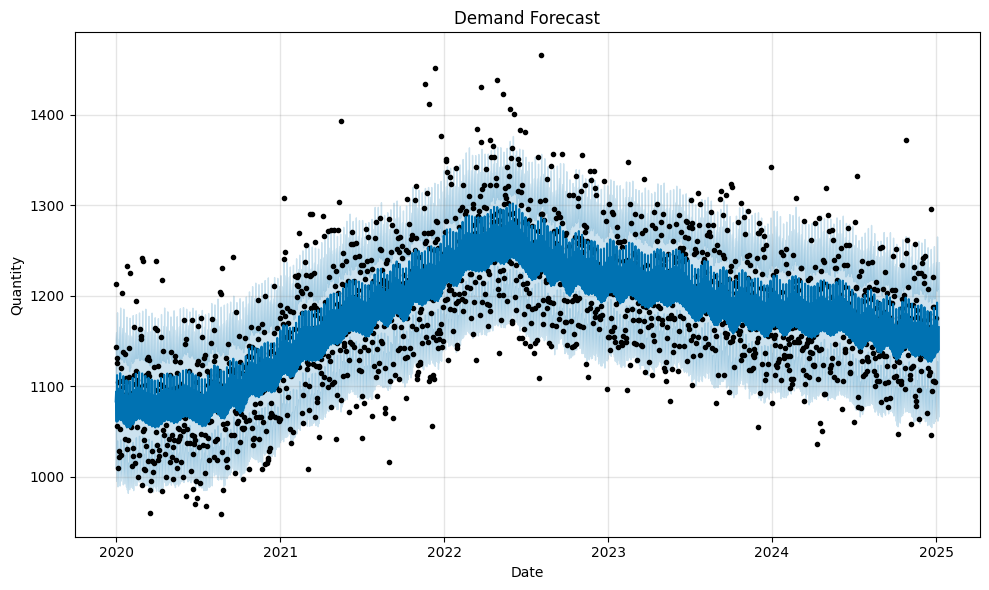

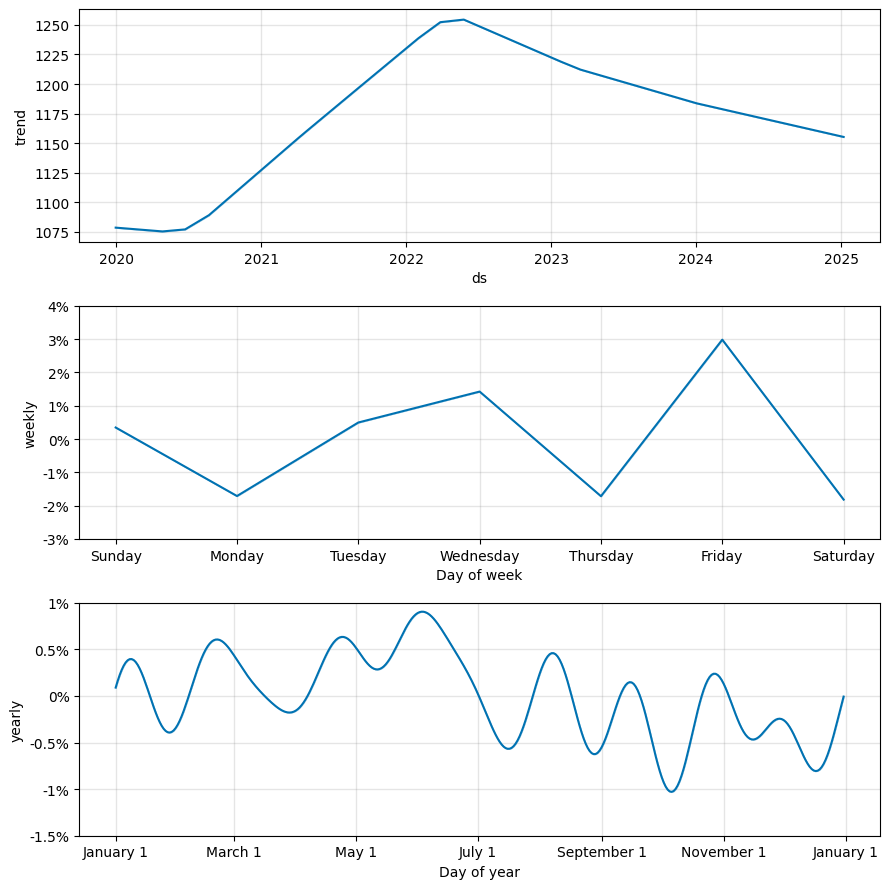


Step 4: Preparing forecast for download


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Forecast saved as prophet_forecast_20250311_052210.csv

Forecasting complete!


In [50]:
#7 Days forecast - 2

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from google.colab import files
import io
import os
from datetime import datetime

# Function to upload a dataset from local computer
def upload_dataset():
    """
    Upload a CSV file through Google Colab's file uploader.

    Returns:
        pd.DataFrame: The uploaded dataset
    """
    print("Please upload your CSV file containing sales data")
    uploaded = files.upload()

    if not uploaded:
        raise ValueError("No file was uploaded")

    # Get the filename and read the CSV
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[filename]))

    print(f"Dataset '{filename}' uploaded successfully with {len(df)} rows")

    # Check for required columns
    required_columns = ['Date', 'Total Quantity']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    print("Dataset preview:")
    display(df.head())

    return df, filename

def calculate_metrics(actual, predicted):
    """Calculate error metrics between actual and predicted values."""
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)

    # Calculate MAPE while avoiding division by zero
    mask = actual != 0
    mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

    return mae, mse, rmse, mape

def preprocess_data(df, years=3):
    """
    Preprocess the data for Prophet modeling.

    Args:
        df (pd.DataFrame): Input dataframe
        years (int): Number of years of data to use

    Returns:
        pd.DataFrame: Processed dataframe ready for Prophet
    """
    # Make a copy to avoid modifying the original
    df_copy = df.copy()

    # Convert Date to datetime with flexible format handling
    try:
        # First try automatic parsing
        df_copy['Date'] = pd.to_datetime(df_copy['Date'], errors='raise')
    except:
        # If that fails, try common formats
        try:
            # Try MM/DD/YY
            df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%m/%d/%y', errors='raise')
        except:
            try:
                # Try MM/DD/YYYY
                df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%m/%d/%Y', errors='raise')
            except:
                try:
                    # Try YYYY-MM-DD
                    df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%Y-%m-%d', errors='raise')
                except:
                    try:
                        # Try DD/MM/YYYY
                        df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%d/%m/%Y', errors='raise')
                    except:
                        try:
                            # Try with inferred format and dayfirst
                            df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='mixed', dayfirst=True, errors='raise')
                        except:
                            # Last attempt with inferred format and dayfirst=False
                            df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='mixed', dayfirst=False)

    print(f"Date range in dataset: {df_copy['Date'].min()} to {df_copy['Date'].max()}")

    # Filter to only keep the last `years` years of data
    if years:
        cutoff_date = df_copy['Date'].max() - pd.DateOffset(years=years)
        df_copy = df_copy[df_copy['Date'] >= cutoff_date]
        print(f"Using data from {cutoff_date} to {df_copy['Date'].max()}")

    # Group by date and sum the quantities
    daily_data = df_copy.groupby('Date')['Total Quantity'].sum().reset_index()

    # Rename columns for Prophet (requires 'ds' for dates and 'y' for target)
    daily_data = daily_data.rename(columns={'Date': 'ds', 'Total Quantity': 'y'})

    return daily_data

def add_features(df):
    """
    Add time-based features to the dataframe.

    Args:
        df (pd.DataFrame): Input dataframe with 'ds' column

    Returns:
        pd.DataFrame: Dataframe with additional features
    """
    # Create a copy of the dataframe to avoid modifying the original
    result = df.copy()

    # Extract date features
    result['day_of_week'] = result['ds'].dt.dayofweek
    result['is_weekend'] = result['day_of_week'].isin([5, 6]).astype(int)
    result['day_of_month'] = result['ds'].dt.day
    result['day_of_year'] = result['ds'].dt.dayofyear
    result['month'] = result['ds'].dt.month
    result['week_of_year'] = result['ds'].dt.isocalendar().week

    # Add lag features
    result['lag_1'] = result['y'].shift(1)
    result['lag_7'] = result['y'].shift(7)

    # Add rolling mean
    result['rolling_mean_7'] = result['y'].rolling(window=7, min_periods=1).mean()

    # Drop NaN values
    result = result.dropna()

    return result

def train_prophet(df, years=3, forecast_days=7):
    """
    Train a Prophet model on the data and forecast future values.

    Args:
        df (pd.DataFrame): Input dataframe
        years (int): Number of years of data to use
        forecast_days (int): Number of days to forecast

    Returns:
        tuple: The Prophet model and forecast dataframe
    """
    # Get preprocessed data
    prophet_df = preprocess_data(df, years)

    # Add features (though Prophet handles seasonality internally)
    df_with_features = add_features(prophet_df)

    # Print the dataset shape after preprocessing
    print(f"Training on {len(prophet_df)} data points")

    # Display aggregated data before training
    print("\nAggregated data preview:")
    display(prophet_df.head())

    # Create and train the Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05
    )

    # Add holidays (uncomment and customize if needed)
    # model.add_country_holidays(country_name='US')

    # Fit the model
    model.fit(prophet_df)

    # Create future dataframe for prediction
    future = model.make_future_dataframe(periods=forecast_days)

    # Make predictions
    forecast = model.predict(future)

    # Evaluate the model on the last forecast_days points
    if len(prophet_df) >= forecast_days:
        # Get the last forecast_days actual values
        actual = prophet_df['y'].iloc[-forecast_days:].values
        # Get the corresponding predictions
        predicted = forecast['yhat'].iloc[-(2*forecast_days):-forecast_days].values

        # Calculate metrics
        mae, mse, rmse, mape = calculate_metrics(actual, predicted)

        print(f"\nModel Evaluation Metrics:")
        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAPE: {mape:.2f}%")

    # Print the forecast for the next forecast_days
    future_forecast = forecast.iloc[-forecast_days:]
    print(f"\nForecast for the next {forecast_days} days:")

    # Create a table for display in Colab
    forecast_table = pd.DataFrame({
        'Date': future_forecast['ds'].dt.date,
        'Forecast': future_forecast['yhat'].round(2),
        'Lower Bound': future_forecast['yhat_lower'].round(2),
        'Upper Bound': future_forecast['yhat_upper'].round(2)
    })

    display(forecast_table)

    return model, forecast

def plot_forecast(model, forecast):
    """
    Plot the forecast results.

    Args:
        model (Prophet): Trained Prophet model
        forecast (pd.DataFrame): Forecast dataframe
    """
    # Plot the forecast
    fig1 = model.plot(forecast)
    plt.title('Demand Forecast')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.tight_layout()
    plt.show()

    # Plot the components
    fig2 = model.plot_components(forecast)
    plt.tight_layout()
    plt.show()

def download_results(forecast, original_filename):
    """
    Prepare forecast results for download.

    Args:
        forecast (pd.DataFrame): Forecast dataframe
        original_filename (str): Original dataset filename
    """
    # Create simplified forecast dataframe
    download_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    download_df.columns = ['Date', 'Forecast', 'Lower_Bound', 'Upper_Bound']

    # Generate output filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f"prophet_forecast_{timestamp}.csv"

    # Save to CSV
    download_df.to_csv(output_filename, index=False)

    # Provide download link
    files.download(output_filename)

    return output_filename

# Main executable cell
def run_prophet_forecasting():
    try:
        # Upload dataset
        print("Step 1: Upload your dataset")
        df, filename = upload_dataset()

        # Get user parameters
        years_input = input("Enter number of years to use for training (default: 3): ")
        years = int(years_input) if years_input.strip() and years_input.isdigit() else 3

        forecast_days_input = input("Enter number of days to forecast (default: 7): ")
        forecast_days = int(forecast_days_input) if forecast_days_input.strip() and forecast_days_input.isdigit() else 7

        print(f"\nStep 2: Training Prophet model using {years} years of data and forecasting {forecast_days} days ahead")

        # Train the model
        model, forecast = train_prophet(df, years, forecast_days)

        print("\nStep 3: Visualizing forecast results")
        # Plot results
        plot_forecast(model, forecast)

        # Prepare download
        print("\nStep 4: Preparing forecast for download")
        output_file = download_results(forecast, filename)
        print(f"Forecast saved as {output_file}")

        print("\nForecasting complete!")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

# Run the forecasting process
run_prophet_forecasting()

In [ ]:
#30 Days forecast

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import files
import io
import os
from datetime import datetime
from prophet.diagnostics import cross_validation, performance_metrics

# Function to upload a dataset from local computer
def upload_dataset():
    """
    Upload a CSV file through Google Colab's file uploader.

    Returns:
        pd.DataFrame: The uploaded dataset
    """
    print("Please upload your CSV file containing sales data")
    uploaded = files.upload()

    if not uploaded:
        raise ValueError("No file was uploaded")

    # Get the filename and read the CSV
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[filename]))

    print(f"Dataset '{filename}' uploaded successfully with {len(df)} rows")

    # Check for required columns
    required_columns = ['Date', 'Total Quantity']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    print("Dataset preview:")
    display(df.head())

    return df, filename

def calculate_metrics(actual, predicted):
    """Calculate error metrics between actual and predicted values."""
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)

    # Calculate MAPE while avoiding division by zero
    mask = actual != 0
    mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

    return mae, mse, rmse, mape, r2

def handle_outliers(df, column='y', method='iqr', threshold=1.5):
    """
    Handle outliers in the data.

    Args:
        df (pd.DataFrame): Input dataframe
        column (str): Column to check for outliers
        method (str): Method to use ('iqr' or 'zscore')
        threshold (float): Threshold for outlier detection

    Returns:
        pd.DataFrame: Dataframe with outliers handled
    """
    df_clean = df.copy()

    if method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
        print(f"Found {outliers.sum()} outliers using IQR method")

        # Replace outliers with bounds instead of removing them
        df_clean.loc[df[column] < lower_bound, column] = lower_bound
        df_clean.loc[df[column] > upper_bound, column] = upper_bound

    elif method == 'zscore':
        from scipy import stats
        z_scores = np.abs(stats.zscore(df[column]))
        outliers = z_scores > threshold
        print(f"Found {outliers.sum()} outliers using Z-score method")

        # Replace outliers with median
        median_value = df[column].median()
        df_clean.loc[outliers, column] = median_value

    return df_clean

def preprocess_data(df, years=3, handle_outliers_flag=True):
    """
    Preprocess the data for Prophet modeling.

    Args:
        df (pd.DataFrame): Input dataframe
        years (int): Number of years of data to use
        handle_outliers_flag (bool): Whether to handle outliers

    Returns:
        pd.DataFrame: Processed dataframe ready for Prophet
    """
    # Make a copy to avoid modifying the original
    df_copy = df.copy()

    # Convert Date to datetime with flexible format handling
    try:
        # First try automatic parsing
        df_copy['Date'] = pd.to_datetime(df_copy['Date'], errors='raise')
    except:
        # If that fails, try common formats
        try:
            # Try MM/DD/YY
            df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%m/%d/%y', errors='raise')
        except:
            try:
                # Try MM/DD/YYYY
                df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%m/%d/%Y', errors='raise')
            except:
                try:
                    # Try YYYY-MM-DD
                    df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%Y-%m-%d', errors='raise')
                except:
                    try:
                        # Try DD/MM/YYYY
                        df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='%d/%m/%Y', errors='raise')
                    except:
                        try:
                            # Try with inferred format and dayfirst
                            df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='mixed', dayfirst=True, errors='raise')
                        except:
                            # Last attempt with inferred format and dayfirst=False
                            df_copy['Date'] = pd.to_datetime(df_copy['Date'], format='mixed', dayfirst=False)

    print(f"Date range in dataset: {df_copy['Date'].min()} to {df_copy['Date'].max()}")

    # Filter to only keep the last `years` years of data
    if years:
        cutoff_date = df_copy['Date'].max() - pd.DateOffset(years=years)
        df_copy = df_copy[df_copy['Date'] >= cutoff_date]
        print(f"Using data from {cutoff_date} to {df_copy['Date'].max()}")

    # Group by date and sum the quantities
    daily_data = df_copy.groupby('Date')['Total Quantity'].sum().reset_index()

    # Rename columns for Prophet (requires 'ds' for dates and 'y' for target)
    daily_data = daily_data.rename(columns={'Date': 'ds', 'Total Quantity': 'y'})

    # Handle outliers if requested
    if handle_outliers_flag:
        daily_data = handle_outliers(daily_data, column='y', method='iqr', threshold=2.0)

    return daily_data

def add_features(df):
    """
    Add time-based features to the dataframe.

    Args:
        df (pd.DataFrame): Input dataframe with 'ds' column

    Returns:
        pd.DataFrame: Dataframe with additional features
    """
    # Create a copy of the dataframe to avoid modifying the original
    result = df.copy()

    # Extract date features
    result['day_of_week'] = result['ds'].dt.dayofweek
    result['is_weekend'] = result['day_of_week'].isin([5, 6]).astype(int)
    result['day_of_month'] = result['ds'].dt.day
    result['day_of_year'] = result['ds'].dt.dayofyear
    result['month'] = result['ds'].dt.month
    result['week_of_year'] = result['ds'].dt.isocalendar().week

    # Add lag features
    result['lag_1'] = result['y'].shift(1)
    result['lag_7'] = result['y'].shift(7)

    # Add rolling mean
    result['rolling_mean_7'] = result['y'].rolling(window=7, min_periods=1).mean()

    # Drop NaN values
    result = result.dropna()

    return result

def find_optimal_parameters(df, initial='180 days', period='30 days', horizon='90 days'):
    """
    Find optimal parameters for Prophet model using cross-validation.

    Args:
        df (pd.DataFrame): Input dataframe with 'ds' and 'y' columns

    Returns:
        dict: Dictionary of optimal parameters
    """
    print("Finding optimal parameters using cross-validation...")

    # Define parameter grid (using a simplified grid to avoid overfitting)
    param_grid = {
        'changepoint_prior_scale': [0.01, 0.05, 0.1],
        'seasonality_prior_scale': [0.1, 1.0, 10.0]
    }

    # Perform grid search
    results = []
    best_rmse = float('inf')
    best_params = {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0}

    total_combinations = len(param_grid['changepoint_prior_scale']) * len(param_grid['seasonality_prior_scale'])
    current = 0

    for cp in param_grid['changepoint_prior_scale']:
        for sp in param_grid['seasonality_prior_scale']:
            current += 1
            print(f"Testing parameters {current}/{total_combinations}: cp={cp}, sp={sp}")

            # Create model with current parameters
            model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                seasonality_mode='multiplicative',
                changepoint_prior_scale=cp,
                seasonality_prior_scale=sp
            )

            model.fit(df)

            # Perform cross-validation
            try:
                df_cv = cross_validation(
                    model=model,
                    initial=initial,
                    period=period,
                    horizon=horizon,
                    parallel='processes'
                )

                # Calculate metrics
                df_p = performance_metrics(df_cv)
                rmse = df_p['rmse'].mean()

                results.append((cp, sp, rmse))
                print(f"  RMSE: {rmse:.4f}")

                # Update best parameters if needed
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {'changepoint_prior_scale': cp, 'seasonality_prior_scale': sp}
            except Exception as e:
                print(f"  Error during cross-validation: {e}")
                continue

    print(f"Best parameters: changepoint_prior_scale={best_params['changepoint_prior_scale']}, "
          f"seasonality_prior_scale={best_params['seasonality_prior_scale']}, RMSE={best_rmse:.4f}")

    return best_params

def train_prophet(df, years=3, forecast_days=7, optimize=True, handle_outliers_flag=True):
    """
    Train a Prophet model on the data and forecast future values.

    Args:
        df (pd.DataFrame): Input dataframe
        years (int): Number of years of data to use
        forecast_days (int): Number of days to forecast
        optimize (bool): Whether to optimize parameters
        handle_outliers_flag (bool): Whether to handle outliers

    Returns:
        tuple: The Prophet model and forecast dataframe
    """
    # Get preprocessed data
    prophet_df = preprocess_data(df, years, handle_outliers_flag)

    # Add features (though Prophet handles seasonality internally)
    df_with_features = add_features(prophet_df)

    # Print the dataset shape after preprocessing
    print(f"Training on {len(prophet_df)} data points")

    # Display aggregated data before training
    print("\nAggregated data preview:")
    display(prophet_df.head())

    # Find optimal parameters if requested
    if optimize and len(prophet_df) >= 180:  # Only optimize if we have enough data
        best_params = find_optimal_parameters(prophet_df)
        changepoint_prior_scale = best_params['changepoint_prior_scale']
        seasonality_prior_scale = best_params['seasonality_prior_scale']
    else:
        # Default parameters
        changepoint_prior_scale = 0.05
        seasonality_prior_scale = 10.0

    # Create and train the Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )

    # Add country holidays (US holidays as an example)
    model.add_country_holidays(country_name='US')

    # Fit the model
    model.fit(prophet_df)

    # Create future dataframe for prediction
    future = model.make_future_dataframe(periods=forecast_days)

    # Make predictions
    forecast = model.predict(future)

    # Evaluate the model on the last forecast_days points
    if len(prophet_df) >= forecast_days:
        # Get the last forecast_days actual values
        actual = prophet_df['y'].iloc[-forecast_days:].values
        # Get the corresponding predictions
        predicted = forecast['yhat'].iloc[-(2*forecast_days):-forecast_days].values

        # Calculate metrics
        mae, mse, rmse, mape, r2 = calculate_metrics(actual, predicted)

        print(f"\nModel Evaluation Metrics:")
        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R²: {r2:.4f}")

    # Print the forecast for the next forecast_days
    future_forecast = forecast.iloc[-forecast_days:]
    print(f"\nForecast for the next {forecast_days} days:")

    # Create a table for display in Colab
    forecast_table = pd.DataFrame({
        'Date': future_forecast['ds'].dt.date,
        'Forecast': future_forecast['yhat'].round(2),
        'Lower Bound': future_forecast['yhat_lower'].round(2),
        'Upper Bound': future_forecast['yhat_upper'].round(2)
    })

    display(forecast_table)

    return model, forecast

def download_results(forecast, original_filename):
    """
    Prepare forecast results for download.

    Args:
        forecast (pd.DataFrame): Forecast dataframe
        original_filename (str): Original dataset filename
    """
    # Create simplified forecast dataframe
    download_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    download_df.columns = ['Date', 'Forecast', 'Lower_Bound', 'Upper_Bound']

    # Generate output filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f"prophet_forecast_{timestamp}.csv"

    # Save to CSV
    download_df.to_csv(output_filename, index=False)

    # Provide download link
    files.download(output_filename)

    return output_filename

# Main executable cell
def run_prophet_forecasting():
    try:
        # Upload dataset
        print("Step 1: Upload your dataset")
        df, filename = upload_dataset()

        # Get user parameters
        years_input = input("Enter number of years to use for training (default: 3): ")
        years = int(years_input) if years_input.strip() and years_input.isdigit() else 3

        forecast_days_input = input("Enter number of days to forecast (default: 7): ")
        forecast_days = int(forecast_days_input) if forecast_days_input.strip() and forecast_days_input.isdigit() else 7

        optimize_input = input("Optimize model parameters? (y/n, default: y): ")
        optimize = optimize_input.lower() != 'n' if optimize_input.strip() else True

        handle_outliers_input = input("Handle outliers? (y/n, default: y): ")
        handle_outliers = handle_outliers_input.lower() != 'n' if handle_outliers_input.strip() else True

        print(f"\nStep 2: Training Prophet model using {years} years of data and forecasting {forecast_days} days ahead")
        print(f"Parameter optimization: {'Enabled' if optimize else 'Disabled'}")
        print(f"Outlier handling: {'Enabled' if handle_outliers else 'Disabled'}")

        # Train the model
        model, forecast = train_prophet(df, years, forecast_days, optimize, handle_outliers)


        # Prepare download
        print("\nStep 4: Preparing forecast for download")
        output_file = download_results(forecast, filename)
        print(f"Forecast saved as {output_file}")

        print("\nForecasting complete!")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

# Run the forecasting process
run_prophet_forecasting()
